<h3>Libraries import and data initialization</h3>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df = pd.read_csv('datasets/autentykacja_eeg_v2.csv', sep=";")
df.head()

,Flag,Delta,Theta,Alpha_low,Alpha_high,Beta_low,Beta_high,Gamma_low,Gamma_high,Attention,Meditation,BlinkStrength
0,1,262466,17013,25803,16111,2057,3064,1616,3629,0,0,-1
1,1,156671,5978,2173,1203,1025,591,361,121,0,0,-1
2,1,420205,9451,2731,3809,1719,4884,2811,1304,0,0,-1
3,1,1011946,57480,4534,10354,7409,2815,5016,1030,0,0,-1
4,1,937903,225754,88704,38777,12663,16150,15275,7426,34,51,-1


<h3>Data preprocessing</h3>

In [5]:
# dropping outliers 

for col in df.columns[1:-3]:
    upper = df[col].quantile(0.99)
    df = df[df[col] < upper]

In [6]:
# splitting and standardizing data

X = df[df.columns[1:-1]]
y = df["Flag"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

<h3>Modelling</h3>

In [37]:
def knn(X_train, y_train, X_test, y_test):
    '''
        Function for determining the best number of neighbors
        Takes splitted data as arguments and iterates through different number of neighbors and generates visual presentation of result on a plot
    '''

    neighbors = np.arange(1, 15)
    train_accuracy = np.empty(len(neighbors))
    test_accuracy = np.empty(len(neighbors))

    for i,k in enumerate(neighbors):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        train_accuracy[i] = knn.score(X_train, y_train)
        test_accuracy[i] = knn.score(X_test, y_test)

    plt.title('Accuracy of different number of neighbors')
    plt.plot(neighbors, test_accuracy, label='Testing accuracy')
    plt.plot(neighbors, train_accuracy, label='Train accuracy')
    plt.legend()
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.show()

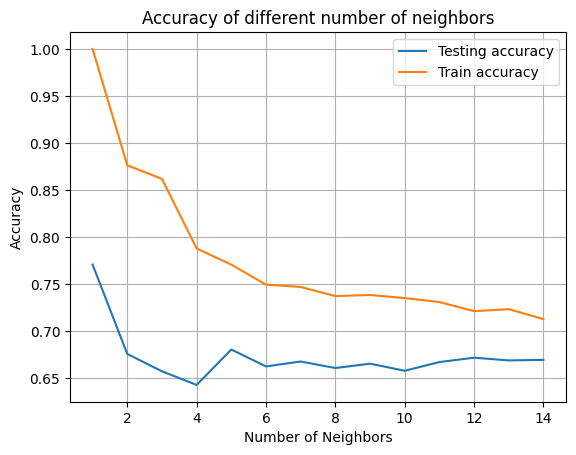

In [38]:
knn(X_train_scaled, y_train, X_test_scaled, y_test)

We can clearly see that our model gives the best results with n_neighbors = 1 <br>
Now let's show a confusion matrix for 1 neighbor

In [52]:
from sklearn.metrics import confusion_matrix

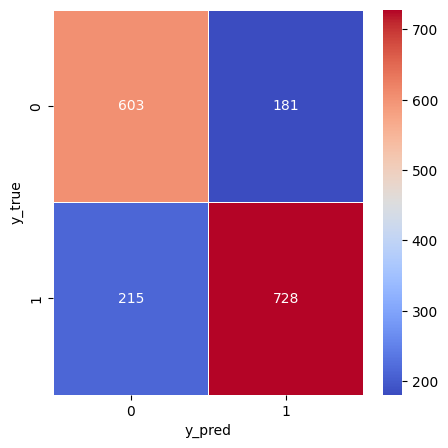

In [54]:
# creating confusion matrix

knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot = True, linewidths= 0.5, cmap='coolwarm', fmt=".0f")
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

ROC Curve

In [55]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

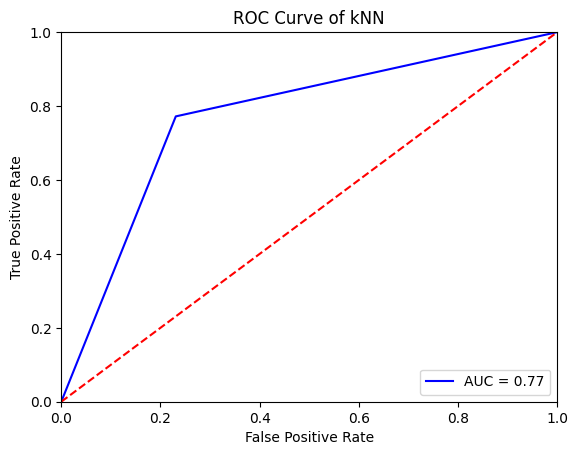

In [59]:
y_scores = knn.predict_proba(X_test_scaled)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

The Area Under the Curve (AUC) is the measure of the ability of a binary classifier to distinguish between classes <br>
The higher the AUC, the better the model’s performance at distinguishing between the positive and negative classes <br>
Our AUC stands at <b>0.77</b>

<h3>PCA</h3>

In [8]:
from sklearn.decomposition import PCA

Text(0.5, 0.85, '95% cut-off threshold')

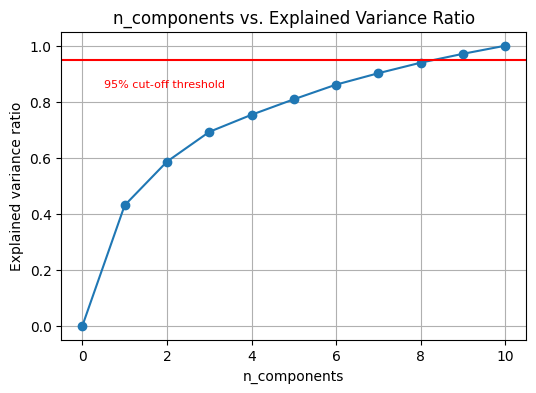

In [27]:
# determining the most optimal number of components for PCA

var_ratio = []
nums = np.arange(11)
for num in nums:
  pca = PCA(n_components=num)
  pca.fit(X_train_scaled)
  var_ratio.append(np.sum(pca.explained_variance_ratio_))

plt.figure(figsize=(6,4))
plt.grid()
plt.plot(nums,var_ratio,marker='o')
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=8)

As I found out, typically we want the explained variance to be between 95%-99%<br>

In [40]:
# fitting data into PCA with n_components = 9 (chosen based on previous results)

pca = PCA(n_components=9)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

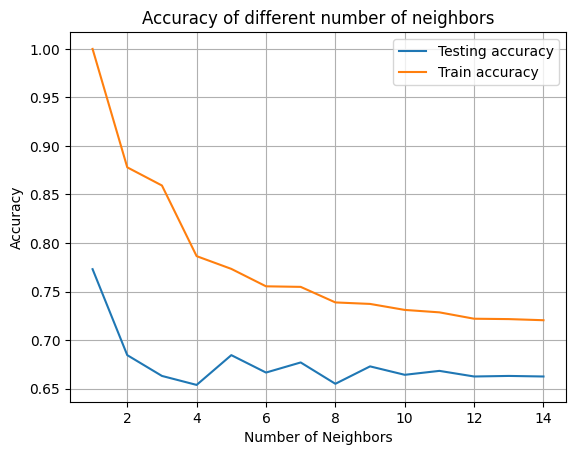

In [42]:
knn(X_train_pca, y_train, X_test_pca, y_test)

<h3>t-SNE</h3>

As I found out, it's a great tool that deals with linearly nonseparable data<br>
At first, we want to find the best perplexity

In [43]:
from sklearn.manifold import TSNE

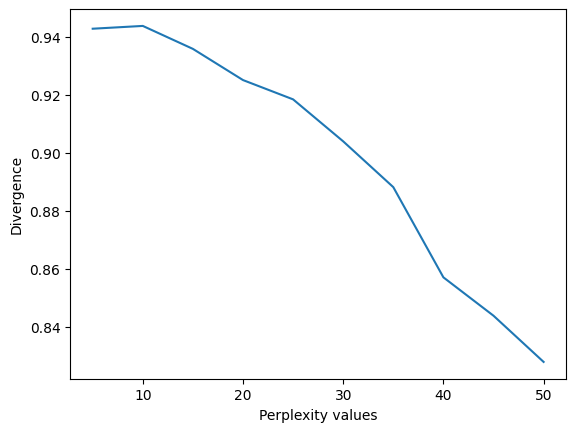

In [50]:
perplexity = np.arange(5, 55, 5)
divergence = []

for i in perplexity:
    model = TSNE(n_components=2, init="pca", perplexity=i)
    reduced = model.fit_transform(X_train)
    divergence.append(model.kl_divergence_)

plt.plot(perplexity, divergence)
plt.xlabel("Perplexity values")
plt.ylabel("Divergence")
plt.show()

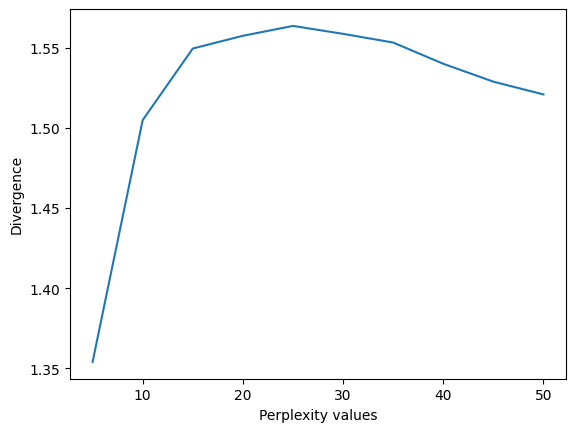

In [51]:
perplexity = np.arange(5, 55, 5)
divergence = []

for i in perplexity:
    model = TSNE(n_components=2, init="pca", perplexity=i)
    reduced = model.fit_transform(X_train_scaled)
    divergence.append(model.kl_divergence_)

plt.plot(perplexity, divergence)
plt.xlabel("Perplexity values")
plt.ylabel("Divergence")
plt.show()

Why divergence is higher for scaled data and why is the curve reversed?